In [2]:
!pip install tf-keras==2.15 --quiet
!pip install tensorflow==2.15 --quiet
!pip install keras==2.15 --quiet

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.7/1.7 MB 28.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 475.2/475.2 MB 3.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.7/1.7 MB 8.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.0/1.0 MB 29.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 5.5/5.5 MB 48.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 442.0/442.0 kB 17.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 77.9/77.9 kB 6.7 MB/s eta 0:00:00
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
tensorstore 0.1.64 requires ml-dtypes>=0.3.1, but you have ml-dtypes 0.2.0 which is incompatible.


In [3]:
# Download the pre-trained weights. No top means it excludes the fully connected layer it uses for classification.
!wget --no-check-certificate \
    https://storage.googleapis.com/mledu-datasets/inception_v3_weights_tf_dim_ordering_tf_kernels_notop.h5 \
    -O /tmp/inception_v3_weights_tf_dim_ordering_tf_kernels_notop.h5

--2024-08-25 08:44:35--  https://storage.googleapis.com/mledu-datasets/inception_v3_weights_tf_dim_ordering_tf_kernels_notop.h5
Resolving storage.googleapis.com (storage.googleapis.com)... 74.125.137.207, 142.250.101.207, 142.251.2.207, ...
Connecting to storage.googleapis.com (storage.googleapis.com)|74.125.137.207|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 87910968 (84M) [application/x-hdf]
Saving to: ‘/tmp/inception_v3_weights_tf_dim_ordering_tf_kernels_notop.h5’

/tmp/inception_v3_w 100%[===================>]  83.84M  91.8MB/s    in 0.9s    

2024-08-25 08:44:36 (91.8 MB/s) - ‘/tmp/inception_v3_weights_tf_dim_ordering_tf_kernels_notop.h5’ saved [87910968/87910968]



In [4]:
from tensorflow.keras.applications.inception_v3 import InceptionV3
import tensorflow as tf
from tensorflow.keras import layers
from tensorflow.keras import Model
from tensorflow.keras.optimizers import RMSprop
from tensorflow.keras.preprocessing.image import ImageDataGenerator
import zipfile
import os
import matplotlib.pyplot as plt


In [5]:
local_weights_file = '/tmp/inception_v3_weights_tf_dim_ordering_tf_kernels_notop.h5'
pretrained_model = InceptionV3(input_shape = (150,150,3),
                                include_top = False, # cancel the last layer in the FCN
                                weights = None)  # also cancel the weights
pretrained_model.load_weights(local_weights_file) # load the weights of the first model to simplify the training process
for layer in pretrained_model.layers:
  layer.trainable = False #cancel the training for the layers in the main model to shorten the time of training and ease the training process

In [6]:
pretrained_model.summary()

Model: "inception_v3"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 input_1 (InputLayer)        [(None, 150, 150, 3)]        0         []                            
                                                                                                  
 conv2d (Conv2D)             (None, 74, 74, 32)           864       ['input_1[0][0]']             
                                                                                                  
 batch_normalization (Batch  (None, 74, 74, 32)           96        ['conv2d[0][0]']              
 Normalization)                                                                                   
                                                                                                  
 activation (Activation)     (None, 74, 74, 32)           0         ['batch_normalizati

In [7]:
last_layer = pretrained_model.get_layer('mixed7') #start our new layers from this layer mixed7
print('Last layer output shape: ', last_layer.output_shape) #know the shape of the last layers to know the shape of the made layer should be
last_output = last_layer.output  # make the shape of the last layer equal the shape of the deleted layer

Last layer output shape:  (None, 7, 7, 768)


In [8]:
# Add the dense layers with the dropout technique
x = layers.Flatten()(last_output) #make flatten to the last layer in the main model
x = layers.Dense(1024, activation = 'relu')(x) #add a new dense layer with 1024 neurons and activation function is relu
x = layers.Dropout(0.2)(x) # make a dropout with key_prop = 0.2 for this layer to ignore some neurons
x = layers.Dense(1, activation = 'sigmoid')(x) # the last dense layer with 1 neuron and activation function sigmoid for the x model
model = Model(pretrained_model.input, x) #build the model with the pre-trained model with the X model we tried to build
model.summary()

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 input_1 (InputLayer)        [(None, 150, 150, 3)]        0         []                            
                                                                                                  
 conv2d (Conv2D)             (None, 74, 74, 32)           864       ['input_1[0][0]']             
                                                                                                  
 batch_normalization (Batch  (None, 74, 74, 32)           96        ['conv2d[0][0]']              
 Normalization)                                                                                   
                                                                                                  
 activation (Activation)     (None, 74, 74, 32)           0         ['batch_normalization[0][0

In [9]:
model.compile(optimizer = RMSprop(learning_rate = 0.0001), loss = 'binary_crossentropy', metrics = ['accuracy'])

In [10]:
# Download the dataset
!wget https://storage.googleapis.com/tensorflow-1-public/course2/cats_and_dogs_filtered.zip

--2024-08-25 08:45:24--  https://storage.googleapis.com/tensorflow-1-public/course2/cats_and_dogs_filtered.zip
Resolving storage.googleapis.com (storage.googleapis.com)... 142.250.101.207, 142.251.2.207, 142.250.141.207, ...
Connecting to storage.googleapis.com (storage.googleapis.com)|142.250.101.207|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 68606236 (65M) [application/zip]
Saving to: ‘cats_and_dogs_filtered.zip’

cats_and_dogs_filte 100%[===================>]  65.43M   113MB/s    in 0.6s    

2024-08-25 08:45:24 (113 MB/s) - ‘cats_and_dogs_filtered.zip’ saved [68606236/68606236]



In [11]:
# Extract the archive
zip_ref = zipfile.ZipFile("./cats_and_dogs_filtered.zip", 'r')
zip_ref.extractall("tmp/")
zip_ref.close()

# Define our example directories and files
base_dir = 'tmp/cats_and_dogs_filtered'

train_dir = os.path.join( base_dir, 'train')
validation_dir = os.path.join( base_dir, 'validation')

# Directory with training cat pictures
train_cats_dir = os.path.join(train_dir, 'cats')

# Directory with training dog pictures
train_dogs_dir = os.path.join(train_dir, 'dogs')

# Directory with validation cat pictures
validation_cats_dir = os.path.join(validation_dir, 'cats')

# Directory with validation dog pictures
validation_dogs_dir = os.path.join(validation_dir, 'dogs')

In [12]:
train_data_gen = ImageDataGenerator(
    rescale = 1.0/255.0,
    rotation_range = 40,
    width_shift_range = 0.2,
    height_shift_range = 0.2,
    shear_range = 0.2,
    zoom_range = 0.2,
    horizontal_flip = True,
)
test_data_gen = ImageDataGenerator(rescale = 1.0/255.0)
train_generator = train_data_gen.flow_from_directory( train_dir,
                                                     batch_size = 20,
                                                      class_mode = 'binary',
                                                      target_size = (150, 150))
validation_generator = train_data_gen.flow_from_directory( validation_dir,
                                                     batch_size = 20,
                                                      class_mode = 'binary',
                                                      target_size = (150, 150))

Found 2000 images belonging to 2 classes.
Found 1000 images belonging to 2 classes.


In [13]:
history = model.fit(train_generator,
                    validation_data = validation_generator,
                    steps_per_epoch = 100,
                    epochs = 20,
                    validation_steps = 50,
                    verbose = 2)

Epoch 1/20
100/100 - 30s - loss: 0.3375 - accuracy: 0.8595 - val_loss: 0.1562 - val_accuracy: 0.9320 - 30s/epoch - 297ms/step
Epoch 2/20
100/100 - 24s - loss: 0.2112 - accuracy: 0.9130 - val_loss: 0.2480 - val_accuracy: 0.9070 - 24s/epoch - 242ms/step
Epoch 3/20
100/100 - 21s - loss: 0.1851 - accuracy: 0.9280 - val_loss: 0.2004 - val_accuracy: 0.9150 - 21s/epoch - 214ms/step
Epoch 4/20
100/100 - 24s - loss: 0.1563 - accuracy: 0.9355 - val_loss: 0.1751 - val_accuracy: 0.9330 - 24s/epoch - 244ms/step
Epoch 5/20
100/100 - 20s - loss: 0.1718 - accuracy: 0.9365 - val_loss: 0.2017 - val_accuracy: 0.9270 - 20s/epoch - 205ms/step
Epoch 6/20
100/100 - 21s - loss: 0.1624 - accuracy: 0.9370 - val_loss: 0.1638 - val_accuracy: 0.9330 - 21s/epoch - 211ms/step
Epoch 7/20
100/100 - 21s - loss: 0.1730 - accuracy: 0.9340 - val_loss: 0.1638 - val_accuracy: 0.9310 - 21s/epoch - 210ms/step
Epoch 8/20
100/100 - 21s - loss: 0.1195 - accuracy: 0.9555 - val_loss: 0.1940 - val_accuracy: 0.9240 - 21s/epoch - 210

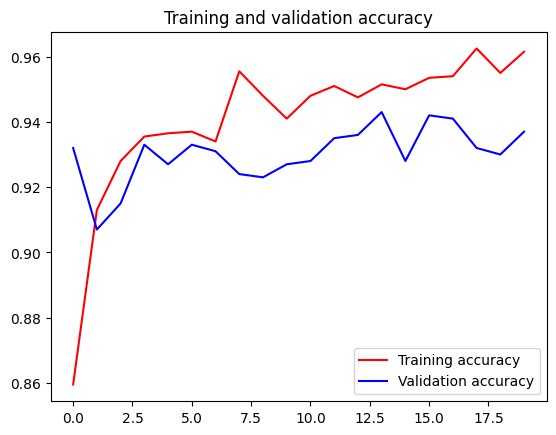

<Figure size 640x480 with 0 Axes>

In [14]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']
loss = history.history['loss']
val_loss = history.history['val_loss']

epochs = range(len(acc))

plt.plot(epochs, acc, 'r', label='Training accuracy')
plt.plot(epochs, val_acc, 'b', label='Validation accuracy')
plt.title('Training and validation accuracy')
plt.legend(loc=0)
plt.figure()


plt.show()